### Построение концептуальной модели

Содержательное описание

Объект моделирования - **Больница скорой помощи**

В больнице скорой помощи имеется 4 мобильные бригады. При поступлении звонка свободная бригада выезжает к больному, где оказывает помощь на месте или везет больного в стационар. После оказания помощи на месте при наличии очереди вызовов бригада сразу отправляется к новому больному.

**Основные элементы системы**:
- **Вызовы** - звонки больных, поступающие в систему.
- **Очередь вызовов** - единая FIFO (First In First Out) очередь вызовов. Вызов становится в очередь сразу после приёма и обрабатывается при наличии свободной мобильной бригады.
- **Мобильные бригады** - идентичные обработчики вызова в количестве 4-х единиц.

Концептуальная модель

**Единица модельного времени** - 1 минута.

**Переменные модели и их распределение во времени**:
- **Поток вызовов** - пуассоновский поток. Новый вызов формируется в случайный момент времени.
- **Количество мобильных бригад** постоянное.
- **Время приёма вызова** распределено нормально.
- **Время обработки вызова** также распределено нормально.

**Допущения и ограничения модели**:
- Приём вызова происходит без формирования очереди на приём.
- Способ обработки вызова не влияет на реализацию программной имитации модели.
- Вызов нельзя отменить. После попадания вызова в очередь он обязательно будет обработан.
- Мобильная бригада обрабатывает вызовы последовательно, т.е. только 1 вызов в определённый момент времени.
- Между временем приёма вызова и временем обработки вызова нет зависимости.

**Отклики модели**:
- **Среднее время ожидания в очереди вызовов `AVG_QUEUE`** - дискретный отклик.
- **Среднее время цикла обслуживания `AVG_SYSTEM`** - дискретный отклик. В цикл обслуживания входят этапы с приёма вызова и до завершения его обработки.
- **Длина очереди `QUEUE_LEN`** - непрерывный отклик.
- **Загруженность бригад `BRIGADES_LOAD`** - непрерывный отклик. Загруженность в момент времени рассчитывается как отношение количества мобильных бригад на обработке вызова в момент времени к количеству мобильных бригад.
- **Количество обработанных вызовов `CALLS_PROC`** - аддитивный отклик. Обработанным вызовом считается вызов, прошедший полный цикл обслуживания.

##### Программная имитационнонная модель

**Параметры модели**:
- `RUN_TIME` - время работы модели в минутах.
- `NUM_BRIGADE` - количество мобильных бригад (4 по описанию модели).
- `FREQUENCY_MIN` - минимальная частота поступления вызовов.
- `FREQUENCY_MAX` - минимальная частота поступления вызовов.
- `NUM_REPLICATIONS` - количество прогонов.
- `AVG_RECEPTION_TIME` - среднее время приёма вызова.
- `AVG_PROCESSING_TIME` - среднее время обработки вызова.

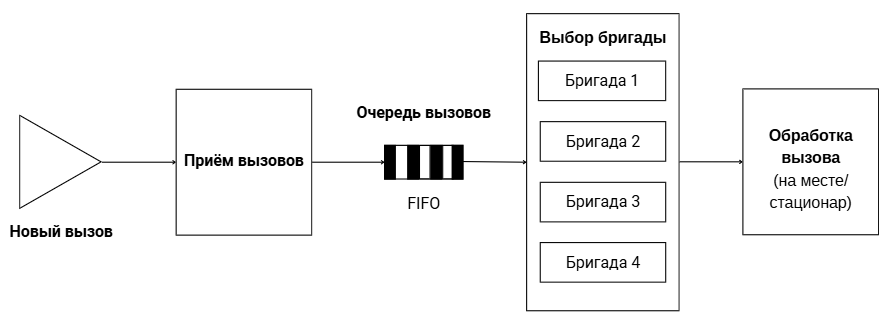

### Программная имитационная модель

In [ ]:
!pip install simpy

In [ ]:
import random
import numpy as np
import simpy
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
RUN_TIME = 420
NUM_BRIGADES = 4

FREQUENCY = 5
AVG_RECEPTION_TIME = 5
AVG_PROCESSING_TIME = 45
NUM_REPLICATIONS = 10

INIT_CALLS = 0

TRACE_MODE = False
WITH_CLEARANCE = True
TEST_MODE = False
WARMUP_MODE = False
WARMUP_TIME = 120

FREQ_MIN = 5
FREQ_MAX = 15

AVG_RECEPTION_TIME_MIN = 5
AVG_RECEPTION_TIME_MAX = 30

AVG_PROCESSING_TIME_MIN = 30
AVG_PROCESSING_TIME_MAX = 60

In [ ]:
CUR_PARAMS = ['AVG_QUEUE', 'AVG_SYSTEM']
CON_PARAMS = ['QUEUE_LEN', 'BRIGADES_LOAD']
ADD_PARAMS = ['CALLS_PROC']
ALL_PARAMS = CUR_PARAMS + CON_PARAMS + ADD_PARAMS

class Results_Collector():
  def __init__(self):
    self.current_values = {param: [] for param in CUR_PARAMS}
    self.continuous_values = {param: [] for param in CON_PARAMS}
    self.additive_values = {param: [] for param in ADD_PARAMS}
    self.replication_values = {param: [] for param in ALL_PARAMS}
    self.freq_avgs = {param: [] for param in ALL_PARAMS}

  def add_current_value(self, param, time, value):
    self.current_values[param].append((time, value))

  def add_continuous_value(self, param, time, value):
    self.continuous_values[param].append((time, value))

  def add_additive_values(self, param, time, value):
    self.additive_values[param].append((time, value))

  def calculate_discrete_avg(self, param):
    values = [point[1] for point in self.current_values[param]]
    return sum(values)/len(values)

  def calculate_continuous_avg(self, param):
    if len(self.continuous_values[param]) < 2:
      return 0
    samples = sorted(self.continuous_values[param], key = lambda x: x[0])
    total_time = samples[-1][0] - samples[0][0]
    if total_time <=0:
      return 0
    weighted_sum = 0
    for i in range(1, len(samples)):
      start_time, start_value = samples[i-1]
      end_time, end_value = samples[i]
      interval = end_time-start_time
      weighted_sum += start_value * interval
    return weighted_sum/total_time

  def finalize_replication(self):
    for param in CON_PARAMS:
      if self.continuous_values[param]:
        self.replication_values[param].append(self.calculate_continuous_avg(param))

    for param in CUR_PARAMS:
      if self.current_values[param]:
        self.replication_values[param].append(self.calculate_discrete_avg(param))

    for param in ADD_PARAMS:
      if self.additive_values[param]:
        self.replication_values[param].append(self.additive_values[param][0][1])
    self.clear_values()

  def calculate_replications_avg(self):
    for param in CUR_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    for param in CON_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    for param in ADD_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    self.replication_values = {param: [] for param in ALL_PARAMS}
    return self.freq_avgs

  def show_results(self, run_time):
    print("== ADDITIVE PARAMS:")
    for param in self.additive_values:
      if self.additive_values[param]:
        print(f"{param} : {self.additive_values[param][0][1]}")

    print("== DISCRETE PARAMS:")
    for param in self.current_values:
      if self.current_values[param]:
        sorted_data = sorted(self.current_values[param], key=lambda x: x[0])
        times = [point[0] for point in sorted_data]
        values = [point[1] for point in sorted_data]
        avg = self.moving_avg(values)
        print(f"{param} avg: {self.calculate_discrete_avg(param)}")
        plt.figure(figsize=(8, 5))
        plt.scatter(times, values, color='skyblue', alpha=0.7, s=50)
        plt.plot(times, avg, color='green', linewidth=2, label='Скользящее среднее')
        plt.axvline(x=run_time, color='lightcoral', linestyle='--', label=f'Время работы модели: {run_time}')
        plt.xlabel('Время')
        plt.ylabel(f'Значение {param}')
        plt.title(f'График {param} во времени')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    print("== CONTINUOUS PARAMS")
    for param in self.continuous_values:
      if self.continuous_values[param]:
        sorted_data = sorted(self.continuous_values[param], key=lambda x: x[0])
        times = [point[0] for point in sorted_data]
        values = [point[1] for point in sorted_data]
        avg = self.moving_avg(values)
        print(f"{param} avg: {self.calculate_continuous_avg(param)}")
        plt.figure(figsize=(8, 5))
        plt.plot(times, avg, color='green', linewidth=2, label='Скользящее среднее')
        plt.plot(times, values, color = 'skyblue', marker='o', linestyle='-', linewidth=1, markersize=4)
        plt.axvline(x=run_time, color='lightcoral', linestyle='--', label=f'Время работы модели: {run_time}')
        plt.xlabel('Время')
        plt.ylabel(f'Значение {param}')
        plt.title(f'График {param}')
        plt.grid(True, alpha=0.3)
        plt.show()

  def show_replications_results(self, replications_num):
    header = f"{'№':<4}"
    for param in ALL_PARAMS:
      header += f" {param:<15}"
    print(header)
    print("-" * (12 + 13 * len(ALL_PARAMS)))
    for i in range(replications_num):
      row = f"{i+1:<4}"
      for param in ALL_PARAMS:
          if i < len(RESULTS_COLLECTOR.replication_values[param]):
              value = RESULTS_COLLECTOR.replication_values[param][i]
              row += f" {value:<15.4f}"
          else:
              row += f" {'N/A':<15}"
      print(row)
    print("-" * (12 + 13 * len(ALL_PARAMS)))
    row = f"{'AVG':<4}"
    for param in ALL_PARAMS:
      avg = sum(RESULTS_COLLECTOR.replication_values[param])/len(RESULTS_COLLECTOR.replication_values[param])
      row += f" {avg:<15.4f}"
    print(row)
    print()

  def moving_avg(self, data):
    result = []
    for i in range(1, len(data)+1):
      avg = sum(data[:i])/i
      result.append(avg)
    return result


  def clear_values(self):
    self.current_values = {param: [] for param in CUR_PARAMS}
    self.continuous_values = {param: [] for param in CON_PARAMS}
    self.additive_values = {param: [] for param in ADD_PARAMS}

In [ ]:
class Emergency_Hospital:
  def __init__(self, env, num_brigades, reception_time, processing_time, trace = False, test = False):
    self.env = env
    self.brigades = simpy.Resource(env, num_brigades)
    self.reception_time = reception_time
    self.processing_time = processing_time
    self.trace = trace
    self.test = test
    self.processed_calls = 0
    self.received_calls = 0
    self.queue_len = 0
    self.busy_brigades = 0
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', 0, 0)
    RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', 0, 0)

  def _trace(self, message):
    if self.trace:
      print(f"[Time: {self.env.now:.2f}] {message}")

  def receive_call(self, call_id):
    self._trace(f"Call {call_id} on line. Time {self.env.now}")
    system_entry_time = self.env.now
    if TEST_MODE: reception_time = self.reception_time
    else: reception_time = max(1, np.random.normal(self.reception_time, 1.5))
    yield self.env.timeout(reception_time)
    self._trace(f"Call {call_id} received. Time {self.env.now}")
    self.received_calls += 1
    self.env.process(self.process_call(call_id, system_entry_time))

  def process_call(self, call_id, system_entry_time):
    queue_entry_time = self.env.now
    self.queue_len += 1
    self._trace(f"Call {call_id} in queue. Time {queue_entry_time}")
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', queue_entry_time, self.queue_len)
    with self.brigades.request() as request:
      yield request
      queue_exit_time = self.env.now
      self.queue_len -= 1
      self._trace(f"Call {call_id} in processing. Time {queue_exit_time}")
      self.busy_brigades += 1
      current_load = self.busy_brigades / NUM_BRIGADES
      RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', queue_exit_time, self.busy_brigades)
      RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', queue_exit_time, self.queue_len)
      RESULTS_COLLECTOR.add_current_value('AVG_QUEUE', queue_exit_time, queue_exit_time - queue_entry_time)
      processing_time = max(10, np.random.normal(self.processing_time, 12))
      yield self.env.timeout(processing_time)
      system_exit_time = self.env.now
      self.busy_brigades -= 1
      current_load = self.busy_brigades / NUM_BRIGADES
      RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', system_exit_time, self.busy_brigades)
      RESULTS_COLLECTOR.add_current_value('AVG_SYSTEM', system_exit_time, system_exit_time - system_entry_time)
      self.processed_calls += 1
      self._trace(f"Call {call_id} processed. Time {system_exit_time}")

In [ ]:
def call_generator(env, emergency_hospital, frequency):

  def start_call(call_id):
    env.process(emergency_hospital.receive_call(call_id))

  call_id = 1
  for i in range(INIT_CALLS):
    start_call(call_id)
    call_id += 1

  while env.now < RUN_TIME:
    if TEST_MODE: interval = frequency/60
    else: interval = random.expovariate(frequency/60)
    yield env.timeout(interval)
    start_call(call_id)
    call_id += 1

In [ ]:
def run_simulation(frequency, reception_time, processing_time):
  warmup = 0 if not WARMUP_MODE else WARMUP_TIME
  env = simpy.Environment()
  emergency_hospital = Emergency_Hospital(env, NUM_BRIGADES, reception_time, processing_time, False, False)

  env.process(call_generator(env, emergency_hospital, frequency))

  if WARMUP_MODE:
    print(f"Starting warmup phase: {warmup} minutes")
    env.run(until=warmup)
    warmup_queue = emergency_hospital.queue_len
    warmup_processing = emergency_hospital.busy_brigades
    warmup_processed = emergency_hospital.processed_calls
    print(f"Warmup completed. State: queue={warmup_queue}, processing={warmup_processing}, processed={warmup_processed}")
    RESULTS_COLLECTOR.clear_values()
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', 0, warmup_queue)
    RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', 0, warmup_processing)
    emergency_hospital.processed_calls = 0
    emergency_hospital.received_calls = 0
    if WITH_CLEARANCE:
      env.run(None)
    else:
      env.run(until=warmup + RUN_TIME)
  else:
    if WITH_CLEARANCE: env.run(None)
    else: env.run(until=RUN_TIME)
  RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', env.now, emergency_hospital.queue_len)
  RESULTS_COLLECTOR.add_additive_values('CALLS_PROC', env.now, emergency_hospital.processed_calls)
  RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', env.now, emergency_hospital.busy_brigades/NUM_BRIGADES)

Single Test

== ADDITIVE PARAMS:
CALLS_PROC : 35
== DISCRETE PARAMS:
AVG_QUEUE avg: 21.197361210551378


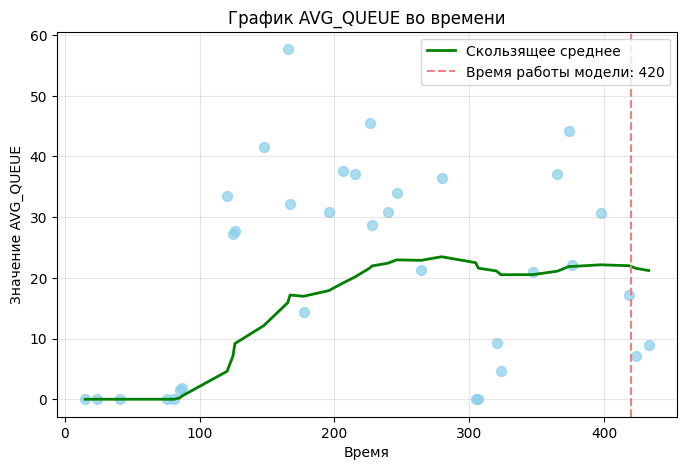

AVG_SYSTEM avg: 73.5343456082351


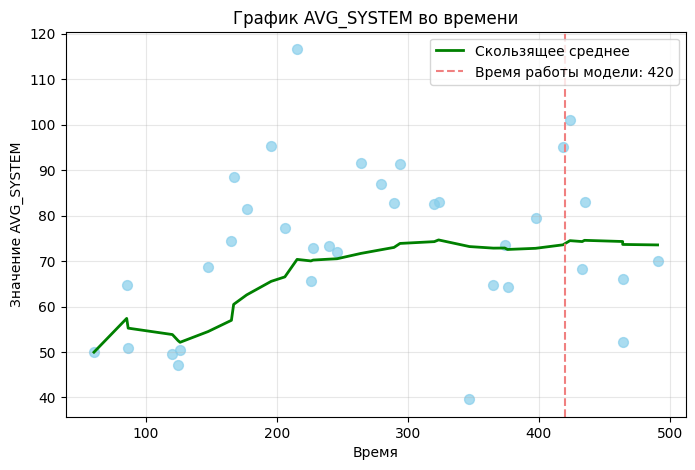

== CONTINUOUS PARAMS
QUEUE_LEN avg: 1.5122479311942394


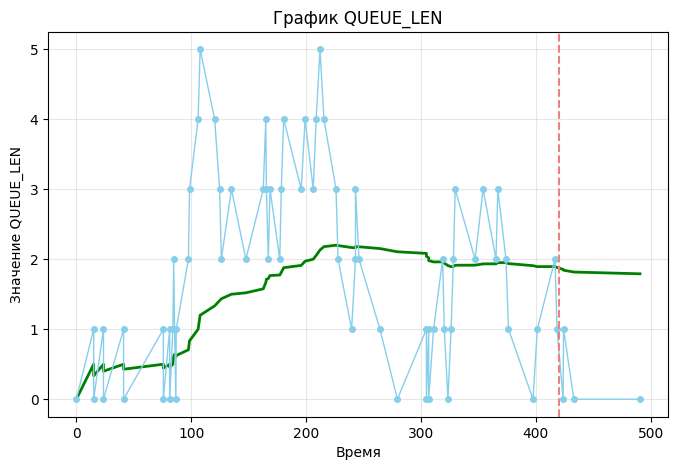

BRIGADES_LOAD avg: 3.361466347102723


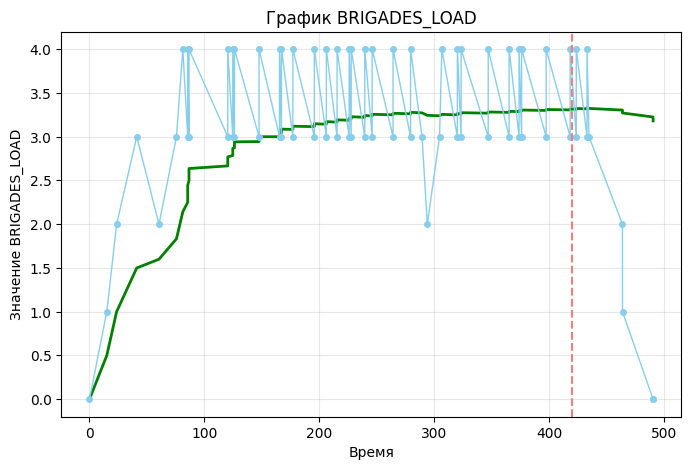

In [ ]:
TEST_MODE = False
RESULTS_COLLECTOR = Results_Collector()
run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
RESULTS_COLLECTOR.show_results(RUN_TIME)

Replications

In [ ]:
TEST_MODE = False
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
RESULTS_COLLECTOR.show_replications_results(NUM_REPLICATIONS)

№    AVG_QUEUE       AVG_SYSTEM      QUEUE_LEN       BRIGADES_LOAD   CALLS_PROC     
-----------------------------------------------------------------------------
1    28.5580         77.9010         2.4535          3.7994          46.0000        
2    7.6144          57.5950         0.5232          3.0905          34.0000        
3    10.5578         60.8494         0.7163          3.0845          32.0000        
4    15.1067         65.8200         1.0053          3.0611          35.0000        
5    8.5760          60.6581         0.5354          2.9585          31.0000        
6    11.7674         60.6113         0.7745          2.8855          31.0000        
7    22.3110         72.2046         1.5745          3.1728          34.0000        
8    50.5366         101.9873        3.7824          3.4888          42.0000        
9    3.4488          50.6245         0.2318          2.8525          32.0000        
10   6.9321          57.2391         0.3978          2.6167          28.

#### Tests

##### Увеличение частоты получения вызовов увеличивает нагрузку на систему

Для параметра AVG_QUEUE гипотеза подтвердилась
Для параметра AVG_SYSTEM гипотеза подтвердилась
Для параметра QUEUE_LEN гипотеза подтвердилась
Для параметра BRIGADES_LOAD гипотеза подтвердилась
Для параметра CALLS_PROC гипотеза подтвердилась


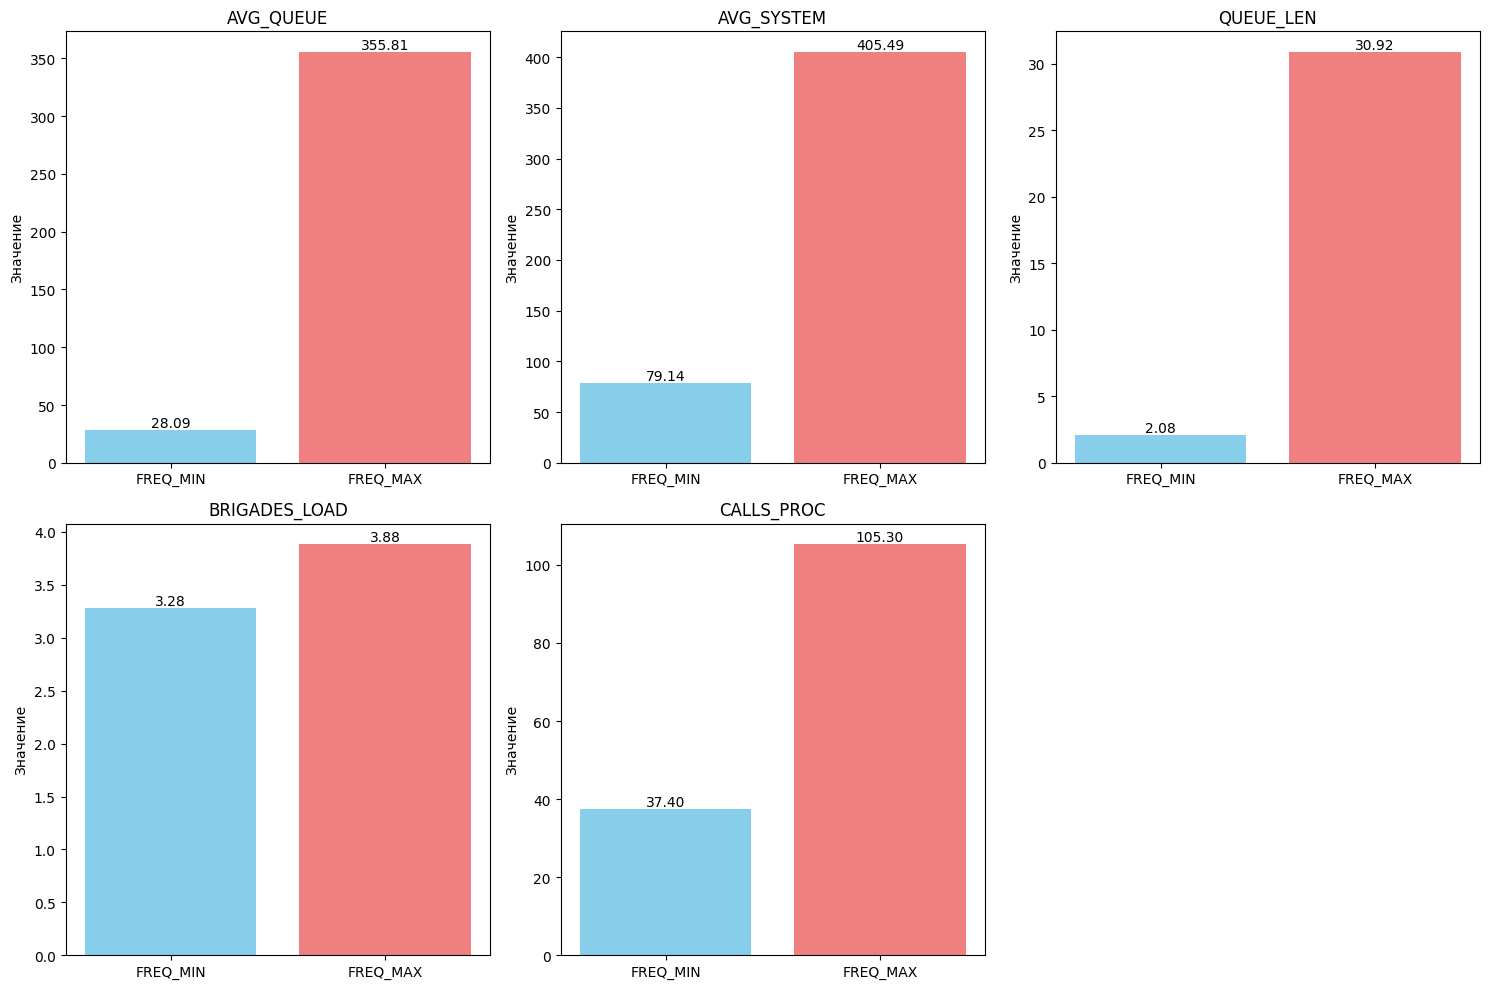

In [ ]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQ_MIN, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQ_MAX, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param in enumerate(ALL_PARAMS):
    values = [results_1[param][0], results_2[param][0]]
    if results_1[param][0] < results_2[param][0]:
      print(f"Для параметра {param} гипотеза подтвердилась")
    else:
      print(f"Для параметра {param} гипотеза не подтвердилась")
    labels = ['FREQ_MIN', 'FREQ_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


##### Увеличение времени обработки вызова увеличивает длину очереди и время в системе

Для параметра AVG_QUEUE гипотеза подтвердилась
Для параметра AVG_SYSTEM гипотеза подтвердилась
Для параметра QUEUE_LEN гипотеза подтвердилась


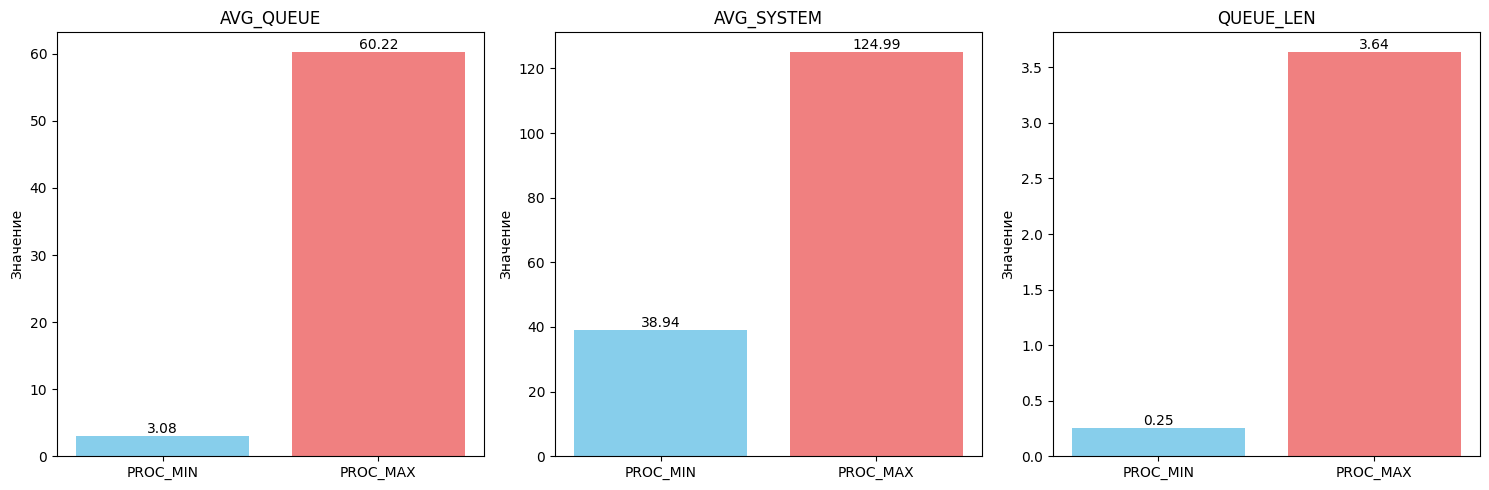

In [ ]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME_MIN)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME_MAX)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, param in enumerate(['AVG_QUEUE', 'AVG_SYSTEM', 'QUEUE_LEN']):
    values = [results_1[param][0], results_2[param][0]]
    if results_1[param][0] < results_2[param][0]:
      print(f"Для параметра {param} гипотеза подтвердилась")
    else:
      print(f"Для параметра {param} гипотеза не подтвердилась")
    labels = ['PROC_MIN', 'PROC_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


##### Увеличение времени получения вызова должно увеличить время нахождения в системе, но уменьшить среднее время нахождения в очереди и длину самой очереди

Для параметра 'AVG_QUEUE' гипотеза подтвердилась
Для параметра 'AVG_SYSTEM' гипотеза подтвердилась
Для параметра 'QUEUE_LEN' гипотеза подтвердилась


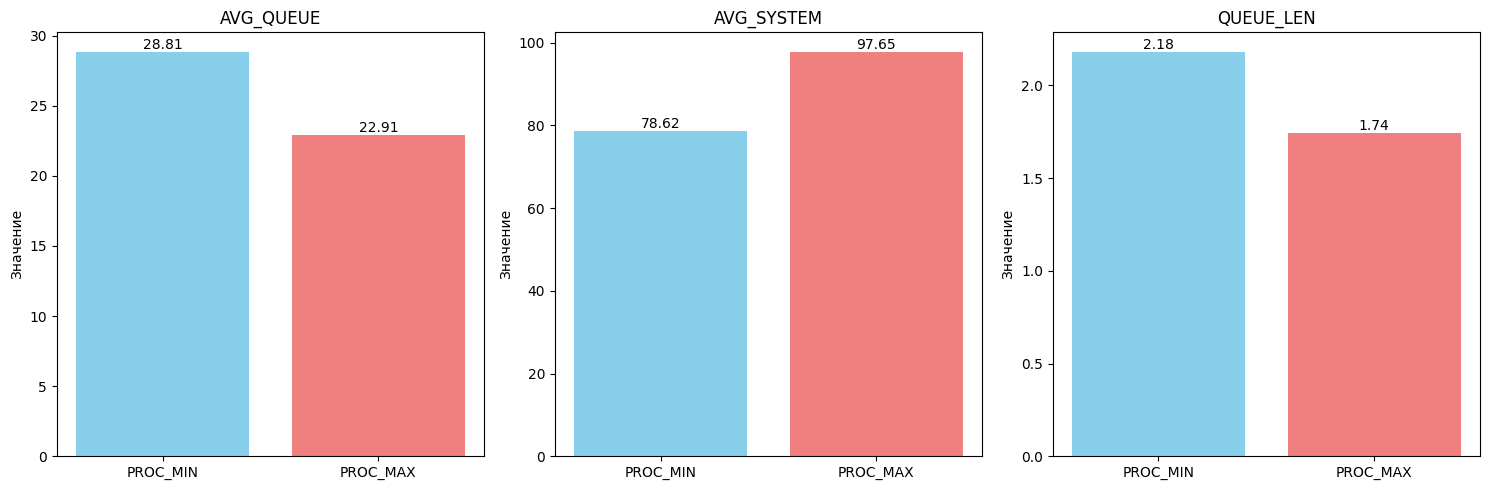

In [ ]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME_MIN, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME_MAX, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

if results_1['AVG_QUEUE'][0] > results_2['AVG_QUEUE'][0]:
  print(f"Для параметра 'AVG_QUEUE' гипотеза подтвердилась")
else: print(f"Для параметра 'AVG_QUEUE' гипотеза не подтвердилась")

if results_1['AVG_SYSTEM'][0] < results_2['AVG_SYSTEM'][0]:
  print(f"Для параметра 'AVG_SYSTEM' гипотеза подтвердилась")
else: print(f"Для параметра 'AVG_SYSTEM' гипотеза не подтвердилась")

if results_1['QUEUE_LEN'][0] > results_2['QUEUE_LEN'][0]:
  print(f"Для параметра 'QUEUE_LEN' гипотеза подтвердилась")
else: print(f"Для параметра 'QUEUE_LEN' гипотеза не подтвердилась")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, param in enumerate(['AVG_QUEUE', 'AVG_SYSTEM', 'QUEUE_LEN']):
    values = [results_1[param][0], results_2[param][0]]
    labels = ['PROC_MIN', 'PROC_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
